### Imports and HTML-content

In [1]:
%run helper.py

In [2]:
from IPython.display import display, HTML
point_to_dist_angle = """

"""

In [3]:
from scipy.stats import multivariate_normal

def calc_likelihoods_for_distributions_and_points(matrix_dist, matrix_points):
    means = matrix_dist[:, 0]
    covariances = matrix_dist[:, 1:]
    likelihoods = np.array([multivariate_normal(mean=means[i], cov=covariances[i]).pdf(matrix_points) for i in range(len(means))])
    
    return likelihoods.T 

In [4]:
import csv
import os
import sys

filter_max_label_number = 1

# csv-header: iteration, class, top, left, bottom, right, center_x, center_y, object_id
def csv_entry_for_graph(graph, relative_path='./csv_files'):
    global filter_max_label_number
    
    classes_dict = {
        0: 'goomba',
        1: 'mario',
        2: 'cloud',
        3: 'ground',
        4: 'bush',
        5: 'box',
        6: 'pipe'
    }

    for i in range(len(graph.x)):
        graph_node = graph.x[i][6:]
        iteration = int(graph_node[6]) # iteration will start at 1
        class_num = int(graph_node[0])
        class_name = classes_dict.get(class_num, 'unknown')
        width = round(float(graph_node[3]), 2)
        height = round(float(graph_node[4]), 2)
        center_x = round(float(graph_node[1]), 2)
        center_y = round(float(graph_node[2]), 2)
        top = round(center_y - (height / 2), 2)
        left = round(center_x - (width / 2), 2)
        bottom = round(center_y + (height / 2), 2)
        right = round(center_x + (width / 2), 2)
        object_id = int(graph_node[7])
    
        file_number = int(graph_node[5])  # write to csv-file with name {file_number:04d}.csv"
        
        csv_entry = [iteration, class_name, top, left, bottom, right, center_x, center_y, object_id]
        file_name = os.path.join(relative_path, f"{file_number:04d}.csv")
        
        if iteration == 1 and os.path.isfile(file_name):
            os.remove(file_name)
    
        with open(file_name, mode='a', newline='') as file:
            writer = csv.writer(file)
            
            if iteration == 1:
                writer.writerow(['iteration', 'class', 'top', 'left', 'bottom', 'right', 'center_x', 'center_y', 'object_id'])
                filter_max_label_number = 1
            
            writer.writerow(csv_entry)

@save_params
def graph_id_tracking(graph_a, graph_b, treshhold=0):
    global filter_max_label_number
    mappings = find_mapping_of_two_graphs(graph_a, graph_b, treshhold)
    
    all_node_ids = torch.tensor([int(node_entry[-1]) for node_entry in graph_b.x])
    not_tracked_nodes = all_node_ids[~all_node_ids.unsqueeze(-1).eq( mappings[:, 1]).any(dim=-1)]

    indicies_graph_b = graph_b.x[:, -1]
    indicies_graph_a = graph_a.x[:, -1]
    max_graph_value = max(max(indicies_graph_a), max(indicies_graph_b))

    # if (graph_b.x[0, -2] > 127): sys.exit(-1)
    for i, object_id in enumerate(indicies_graph_b):
        if(object_id in not_tracked_nodes):
            graph_b.x[i, -1] = filter_max_label_number
            # print('filter_max_label_number', filter_max_label_number)
            filter_max_label_number += 1
        else:
            # mapping_idx = int(torch.where(mappings[:, 1] == int(object_id))[0]) 
            mapping_idx_tensor = torch.where(mappings[:, 1] == object_id)[0]
            mapping_idx = mapping_idx_tensor.item()
            graph_b.x[i, -1] = mappings[mapping_idx, 0]
            # print('mappings', mappings[mapping_idx, 0])


In [5]:
def create_graph_data(csv_file_name, iteration):
    classes_dict = {
        'goomba': 0,
        'mario': 1,
        'cloud': 2,
        'ground': 3,
        'bush': 4,
        'box': 5,
        'pipe': 6
    }
    
    class_names, boxes = get_classnames_boxes_from_csv(csv_file_name, iteration)
    num_nodes = len(boxes)
    edge_connections = cartesian_product_for_nodes(range(num_nodes))
    node_features = []
    matrix = np.empty((0, 2))
    normal_dist = [0, 0, 10, 0, 0, 10] # mu1, mu2, sig00, sig01, sig10, sig11
    dataset_number = int(csv_file_name.split('/')[-1].split('.')[0])

    if num_nodes == 1:
        box = boxes[0]
        width, height = abs(box['left'] - box['right']), abs(box['top'] - box['bottom'])
        # node_feature: (normal-distribution, class-label, x-val, y-val, width, height, dataset_number, iteration, id)
        node_features.append((*normal_dist, classes_dict[class_names[0]], box['center_x'], \
                              box['center_y'], width, height, dataset_number, iteration, 0))
        
        node_features = torch.tensor(node_features, dtype=torch.float)
        
        return Data(
            x=node_features,
            edge_index=torch.tensor([0]),
            edge_attr=torch.tensor([0])
        )
        
    for i, box in enumerate(boxes):
        new_row = np.array([[box['center_x'], box['center_y']]])
        matrix = np.vstack((matrix, new_row))

        width, height = abs(box['left'] - box['right']), abs(box['top'] - box['bottom'])
        # node_feature: (normal-distribution, class-label, x-val, y-val, width, height, dataset_number, iteration, id)
        node_features.append((*normal_dist, classes_dict[class_names[i]], box['center_x'], \
                              box['center_y'], width, height, dataset_number, iteration, i))
    
    dists, angles = dist_angle_from_matrix(matrix, edge_connections)
    
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_connections = torch.tensor(edge_connections)
    edges_features =  torch.tensor(np.stack((dists, angles), axis=-1))
    
    data = Data(
        x=node_features,
        edge_index=edge_connections.t().contiguous(),
        edge_attr=edges_features
    )

    return data

In [6]:
def calc_point_indices_to_distributions(distributions, points, treshhold_likelihood = 0):
    if points.shape[0] == 0:
        return np.zeros(distributions.shape[0]) - 1
    
    if points.shape[0] == 1 and distributions.shape[0] == 1:
        likelihood_entries = calc_likelihoods_for_distributions_and_points(distributions, points)
    
        if likelihood_entries < treshhold_likelihood: return np.array([-1])
        return np.array([0])

    if points.shape[0] == 1:
        likelihood_entries = calc_likelihoods_for_distributions_and_points(distributions, points)
        likelihood_indicies_to_filter = likelihood_entries < treshhold_likelihood
        likelihood_entries[likelihood_indicies_to_filter] = 0
        
        if torch.sum(1 - torch.tensor(likelihood_indicies_to_filter, dtype=int)) == 0: # Under threshhold
            return np.array([-1])
        else:
            return np.array([np.argmax(likelihood_entries)])
    
    likelihoods = calc_likelihoods_for_distributions_and_points(distributions, points)
    sorted_indices = np.argsort(likelihoods, axis=0)
    ranks = np.zeros_like(likelihoods, dtype=int)
    n_rows, n_cols = likelihoods.shape
    ranks[sorted_indices, np.arange(n_cols)] = np.tile(np.arange(n_rows), (n_cols, 1)).T
    
    mask_binary = np.array((n_rows - ranks) <= n_cols, dtype=int)
    cumsum_array = np.cumsum(mask_binary, axis=0)
    
    s = min(n_rows, n_cols)
    extended_likelihood_entries = np.zeros((s+1, n_cols + 1))
    
    mask  = np.array((n_rows - ranks) <= n_cols)
    
    points_to_consider = np.where(np.any(mask, axis=1))[0]
    filtered_points = points[points_to_consider]
    
    likelihood_entries = calc_likelihoods_for_distributions_and_points(distributions, filtered_points)

    if len(filtered_points) != 1:
        likelihood_indicies_to_filter = likelihood_entries < treshhold_likelihood
        # punish points that should be filtered out
        likelihood_entries[likelihood_indicies_to_filter] = 0
        likelihood_entries += 1e-50
        
        inv_percentage_of_likelihood = np.log(likelihood_entries)/ np.sum(np.log(likelihood_entries), axis=0)
        # percentage_of_likelihood = (1 / inv_percentage_of_likelihood) / np.sum( (1 / inv_percentage_of_likelihood), axis=0)
        # percentage_of_likelihood = inv_percentage_of_likelihood
        
        cost_matrix = np.log(inv_percentage_of_likelihood)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        max_index = max(col_ind) + 1
        points_to_distributions = np.zeros(max_index, dtype=row_ind.dtype) - 1
        
        points_to_distributions[col_ind] = row_ind
    
        # if punished points still come up ahead, set the association to -1
        for point_index, distribution_index in enumerate(col_ind):
            if likelihood_indicies_to_filter[point_index, distribution_index]:
                points_to_distributions[point_index] = -1
        return points_to_distributions
    
    else: # case where we have one distribution, also only one point to consider
        if(likelihood_entries[0] < treshhold_likelihood):
            return np.array([-1])
        else:
            return np.array([points_to_consider])

def classes_points_distributions_ids_from_graph(graph):
    graph = graph.x
    return torch.clone(graph[:, 6]), torch.clone(graph[:, :6]), torch.clone(graph[:, 7:9]), torch.clone(graph[:, -1])

def indicies_of_filterted_array_entries(filtered_indicies, relative_indicies):
    return np.where(filtered_indicies)[0][relative_indicies]

def calculate_sse_for_distributions_and_points(graph_a, graph_b, mappings):
    node_attr_a = classes_points_distributions_ids_from_graph(graph_a)
    node_attr_b = classes_points_distributions_ids_from_graph(graph_b)
    
    dist_indicies = mappings[:, 0]
    distributions = node_attr_a[1][dist_indicies]
    distributions[:, :2] +=  np.array(node_attr_a[2][dist_indicies])[:]
    distributions = np.array(distributions.reshape(distributions.shape[0], -1, 2))
    
    points = node_attr_b[2][mappings[:, 1]]
    
    likelihoods = torch.tensor(calc_likelihoods_for_distributions_and_points(distributions, points))
    if likelihoods.shape[0] == 1: return likelihoods
    
    return likelihoods[mappings[:, 0], mappings[:, 1]]

In [7]:
# def plot_distributions__with_ids_with_colored_points(distributions, ids, points, points_to_distribution, n_std=1.96):
#     fig, ax = plot_confidence_ellipses(distributions, n_std)
    
#     # Plot all points in a default color (black)
#     ax.plot(points[:, 0], points[:, 1], 'ko', label='All Points')

#     # Use the same colormap to get consistent colors
#     cmap = plt.get_cmap('viridis')
#     colors = cmap(np.linspace(0, 1, len(distributions)))

#     for dist_idx, point_idx in enumerate(points_to_distribution):
#         if point_idx == -1: continue
#         ax.plot(points[point_idx, 0], points[point_idx, 1], 'o', color=colors[dist_idx], label=f'Point to Distribution {dist_idx}')
    
#     ax.legend()
#     return plt, ax

In [8]:
from itertools import cycle
from matplotlib.patches import Polygon

def create_ellipse_points(mean, cov, n_std=1.96, n_points=100):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    
    t = np.linspace(0, 2*np.pi, n_points)
    ellipse_x = n_std * np.sqrt(eigenvalues[0]) * np.cos(t)
    ellipse_y = n_std * np.sqrt(eigenvalues[1]) * np.sin(t)
    
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    
    ellipse_points = np.dot(np.column_stack([ellipse_x, ellipse_y]), R.T) + mean
    return ellipse_points[:, 0], ellipse_points[:, 1]

def plot_confidence_ellipses(distributions, n_std=1.96):
    fig, ax = plt.subplots()

    cmap = plt.get_cmap('viridis')
    colors = cycle(cmap(np.linspace(0, 1, len(distributions))))
    patches = []

    for idx, dist in enumerate(distributions):
        mean, cov = dist[0], np.array([dist[1], dist[2]])
        x, y = create_ellipse_points(mean, cov, n_std)
        
        color = next(colors)
        
        # Create polygon
        polygon_points = np.column_stack([x, y])
        poly = Polygon(polygon_points, closed=True, fill=True, color=color, alpha=0.5)
        ax.add_patch(poly)
        patches.append(poly)

    ax.set_title('Confidence Ellipses')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(patches, ['Distribution {}'.format(i) for i in range(len(distributions))])
    ax.axis('equal')

    return plt, ax

def plot_distributions_with_colored_points(distributions, points, points_to_distribution, n_std=1.96):
    fig, ax = plot_confidence_ellipses(distributions, n_std)
    
    # Plot all points in a default color (black)
    ax.plot(points[:, 0], points[:, 1], 'ko', label='All Points')

    # Use the same colormap to get consistent colors
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(distributions)))

    for dist_idx, point_idx in enumerate(points_to_distribution):
        if point_idx == -1: continue
        ax.plot(points[point_idx, 0], points[point_idx, 1], 'o', color=colors[dist_idx], label=f'Point to Distribution {dist_idx}')
    
    ax.legend()
    return plt, ax

In [9]:
def get_distribution_from_graph(graph):
    node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)

    distributions_a = node_attributes_a[1]
    points_a = node_attributes_a[2]
    distributions_a[:, :2] +=  points_a[:, :]
    
    return np.array(distributions_a.reshape(distributions_a.shape[0], -1, 2))

def find_mapping_of_two_graphs(graph_a, graph_b, treshhold=0):
    node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)
    node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)
    
    distributions_a = get_distribution_from_graph(graph_a)
    points_b = node_attributes_b[2]
    
    points_to_distributions = calc_point_indices_to_distributions(distributions_a, points_b, 0)

    tensor1 = node_attributes_a[3]
    tensor2 = np.where(
        points_to_distributions != -1, 
        node_attributes_b[3][points_to_distributions], 
        -1
    ).flatten()
    
    return torch.tensor(list(zip(tensor1.tolist(), tensor2.tolist())), dtype=int)

def id_mapping_to_idx_mapping(graph_a, graph_b, mapping):
    node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)
    node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)

    node_ids_a = node_attributes_a[3]
    node_ids_b = node_attributes_b[3]

    combined_ids = torch.tensor(list(zip(node_ids_a.tolist(), node_ids_b.tolist())), dtype=int)
    
    result_tensor = torch.empty_like(combined_ids, dtype=torch.long)

    # Fill the first column with index values
    result_tensor[:, 0] = torch.arange(combined_ids.size(0))
    
    # Replace the second column with mapped values
    for idx, pair in enumerate(combined_ids):
        original_value = pair[1].item()
        mapped_value = mapping[mapping[:, 0] == original_value]
        if len(mapped_value) > 0:
            result_tensor[idx, 1] = mapped_value[0, 1]
        else:
            result_tensor[idx, 1] = -1

    return result_tensor

def visualize_graph_idx_mapping(graph_a, graph_b, mapping, n_std=1.96):
    node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)
    node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)

    distributions_a = get_distribution_from_graph(graph_a)
    points_b = node_attributes_b[2]

    fig, ax = plot_confidence_ellipses(distributions_a, n_std)
    
    # Plot all points in a default color (black)
    ax.plot(points_b[:, 0], points_b[:, 1], 'ko', label='All Points')

    # Use the same colormap to get consistent colors
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(distributions_a)))

    for dist_idx, point_idx in mapping:
        if point_idx == -1: continue
        ax.plot(points_b[point_idx, 0], points_b[point_idx, 1], 'o', color=colors[dist_idx], label=f'Point to Distribution {dist_idx}')
    
    ax.legend()
    return plt, ax

# for i in range(500, 550):
#     print(i)
#     graph_a = train_dataset[i]
#     graph_b = train_dataset[i+1]

#     id_mapping = find_mapping_of_two_graphs(graph_a, graph_b)
#     idx_mapping = id_mapping_to_idx_mapping(graph_a, graph_b, id_mapping)
#     visualize_graph_idx_mapping(graph_a, graph_b, idx_mapping)
#     time.sleep(0.01)

In [10]:
import os
import csv
import time
import cv2
import numpy as np
import pandas as pd
from hashlib import sha256

def get_name_and_boxes_for_iteration(csv_file_name, iteration):
    names = []
    boxes = []
    
    with open(csv_file_name, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if int(row['iteration']) == iteration:
                names.append(row['class'])
                boxes.append({
                    'top': float(row['top']),
                    'left': float(row['left']),
                    'bottom': float(row['bottom']),
                    'right': float(row['right']),
                    'center_x': float(row['center_x']),
                    'center_y': float(row['center_y']),
                    'object_id': int(row['object_id'])
                })
    
    return names, boxes

def generate_color(object_id):
    """
    Generate a unique color for each object_id.
    Uses a hash function to create unique colors.
    """
    hash_object = sha256(str(object_id).encode())
    hex_color = hash_object.hexdigest()[:6]
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def draw_boxes_to_canvas(csv_file_name, image_widget, x_limit=240, y_limit=240, frame_delay=0.01):
    df = pd.read_csv(csv_file_name)
    num_iterations = int(df.iloc[-1]['iteration']) + 1
    for iteration in range(num_iterations):
        names, boxes = get_name_and_boxes_for_iteration(csv_file_name, iteration)
        
        height, width = y_limit, x_limit
        canvas = np.ones((height, width, 3), dtype=np.uint8) * 255  # Create a white background
        
        # Draw the file name in the top-left corner
        file_name_text = f"File: {os.path.basename(csv_file_name)}"
        cv2.putText(canvas, file_name_text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        for name, box in zip(names, boxes):
            top = int(box['top'])
            left = int(box['left'])
            bottom = int(box['bottom'])
            right = int(box['right'])
            color = generate_color(box['object_id'])  # Get unique color for object_id
            
            cv2.rectangle(canvas, (top, left), (bottom, right), color, 2)
            cv2.putText(canvas, name, (top, left - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        _, buffer = cv2.imencode('.jpg', canvas)
        image_widget.value = buffer.tobytes()

        time.sleep(frame_delay)

def replay_csv_files_from_directory(directory_name, image_widget):
    for file_name in sorted(os.listdir(directory_name)):
        if file_name.endswith('.csv'):
            csv_file_path = os.path.join(directory_name, file_name)
            draw_boxes_to_canvas(csv_file_path, image_widget)

### Code

### Build Graph

In [11]:
dataset = []
for i in range(4):
    csv_file_name = f"/workspaces/jupyterlite/content/pytroch-geometric/mario-tracking-data/{i:04d}.csv"
    df = pd.read_csv(csv_file_name)
    num_iterations = int(df.iloc[-1]['iteration']) # we start at index 1, so no need for `+ 1`
    
    for iteration in range(1, num_iterations):
        graph_data = create_graph_data(csv_file_name, iteration)
        dataset.append(graph_data)

train_dataset = dataset[:int(0.8 * len(dataset))]
test_dataset = dataset[int(0.8 * len(dataset)):]

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

/workspaces/jupyterlite/content/pytroch-geometric/helper.py:73: RuntimeWarning: invalid value encountered in divide
  return np.linalg.norm(val_edge_pairs, axis=1), np.rad2deg(np.arctan(val_edge_pairs[:, 1] / val_edge_pairs[:, 0]))
/workspaces/jupyterlite/content/pytroch-geometric/helper.py:73: RuntimeWarning: divide by zero encountered in divide
  return np.linalg.norm(val_edge_pairs, axis=1), np.rad2deg(np.arctan(val_edge_pairs[:, 1] / val_edge_pairs[:, 0]))
/usr/local/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### Message Passing

In [12]:
class SimpleGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super().__init__()
        self.conv1 = GATConv(in_channels, out_channels, heads=1, add_self_loops=False)

    def forward(self, x, edge_index, target_node):
        out = self.conv1(x, edge_index)

#### Loss

The Loss will be the SSE of the likelihoods that the points of frame i+1 belong to the distributions that were created from the graph on frame i.


In [13]:
# graph_a = train_dataset[729]
# graph_b = train_dataset[730]
# mappings = find_mapping_of_two_graphs(graph_a, graph_b)
# # calculate_sse_for_distributions_and_points(graph_a, graph_b, mappings)
# mappings

In [14]:
# 181,pipe,184.03,176.08,215.29,207.41,191.74,199.66,5
# 181,goomba,40.02,192.69,55.04,208.47,200.58,47.53,3
# 181,box,54.96,144.2,135.95,158.78,151.49,95.46,1
# 181,mario,111.22,171.09,126.66,186.69,178.89,118.94,0
# 181,box,88.64,80.0,103.0,94.96,87.48,95.82,2
# 181,box,0.17,143.9,7.0,158.91,151.4,3.58,4

# 182,box,52.66,144.18,132.96,158.82,151.5,92.81,1
# 182,mario,111.83,175.04,126.71,190.72,182.88,119.27,0
# 182,goomba,35.98,192.72,51.03,208.52,200.62,43.51,3
# 182,pipe,180.88,176.06,211.88,207.4,191.73,196.38,5
# 182,box,85.57,79.99,100.01,94.97,87.48,92.79,2
# 182,box,0.15,144.0,4.11,159.0,151.5,2.13,4

# 183,pipe,177.88,176.09,209.32,207.39,191.74,193.6,5
# 183,box,82.59,80.0,97.04,94.97,87.49,89.82,2
# 183,goomba,32.99,192.8,48.09,208.56,200.68,40.54,3
# 183,box,49.14,144.22,129.9,158.8,151.51,89.52,1
# 183,mario,112.29,180.27,126.62,194.99,187.63,119.46,0

#### Graph to CSV

In [15]:
for graph in train_dataset:
    csv_entry_for_graph(graph, 'graph_to_csv')

In [16]:
for i in range(len(train_dataset) - 1):
    graph_a = train_dataset[i]
    graph_b = train_dataset[i+1]
    graph_id_tracking(graph_a, graph_b)
    csv_entry_for_graph(graph_a, 'graph_to_csv-applied_tracking')

/tmp/ipykernel_933600/2994302452.py:26: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(list(zip(tensor1.tolist(), tensor2.tolist())), dtype=int)


IndexError: index 3 is out of bounds for dimension 0 with size 1

In [80]:
def save_params(func):
    def wrapper(*args, **kwargs):
        globals().update({k: v for k, v in zip(func.__code__.co_varnames, args)})
        return func(*args, **kwargs)
    return wrapper

def generate_color_for_idx(object_id):
    """
    Generate a unique color for each object_id using a hash function.
    """
    hash_object = sha256(str(object_id).encode())
    hex_color = hash_object.hexdigest()[:6]
    return tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))

def plot_confidence_ellipses_with_ids(distributions, ids, n_std=1.96):
    fig, ax = plt.subplots()

    all_x, all_y = [], []
    patches = []
    for idx, dist in enumerate(distributions):
        mean, cov = dist[0], np.array([dist[1], dist[2]])
        x, y = create_ellipse_points(mean, cov, n_std)
    
        all_x.extend(x)
        all_y.extend(y)
        
        # Generate color based on ID
        color = generate_color_for_idx(ids[idx])
        
        # Create polygon
        polygon_points = np.column_stack([x, y])
        poly = Polygon(polygon_points, closed=True, fill=True, color=color, alpha=0.5)
        ax.add_patch(poly)
        patches.append(poly)
    
    # ax.set_xlim(min(all_x), max(all_x))
    # ax.set_ylim(min(all_y), max(all_y))
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    
    ax.set_title('Confidence Ellipses')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', 'box')
    
    # Create a legend with IDs
    ax.legend(patches, [f'Distribution {id_}' for id_ in ids])

    return plt, ax

In [84]:
def plot_distributions_with_ids_with_colored_points(distributions, ids, points, points_to_distribution, n_std=1.96):
    plt, ax = plot_confidence_ellipses_with_ids(distributions, ids, n_std)

    for dist_idx, point_idx in enumerate(points_to_distribution):
        if point_idx == -1: 
            continue
        color = generate_color_for_idx(ids[dist_idx])
        ax.plot(points[point_idx, 0], points[point_idx, 1], 'o', color=color)

    # Rotate the graph 90-degrees clock-wise
    ax.set_xlim(ax.get_ylim()[::-1])
    ax.set_ylim(ax.get_xlim()[::-1])
    ax.figure.canvas.draw()
    
    return plt, ax

def end_to_end_visualize_graphs_by_distributions_and_points(graph_a, graph_b):
    node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)
    node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)
    
    distributions_a = get_distribution_from_graph(graph_a)
    ids_a = [int(x) for x in node_attributes_a[3].tolist()]
    points_b = node_attributes_b[2]

    points_to_distributions = calc_point_indices_to_distributions(distributions_a, points_b, 0)
    plot_distributions_with_ids_with_colored_points(distributions_a, ids_a, points_b, points_to_distributions, n_std=1.96)[0].show()

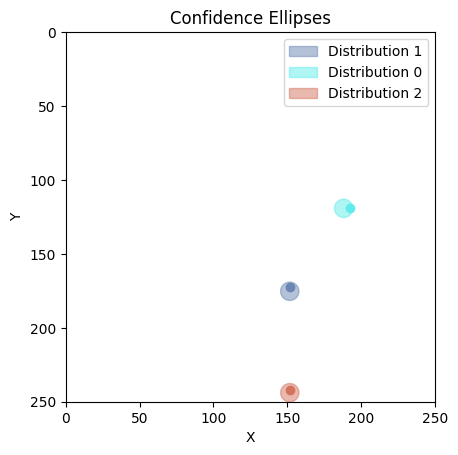

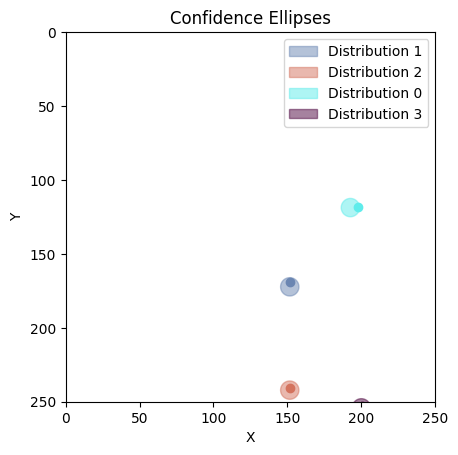

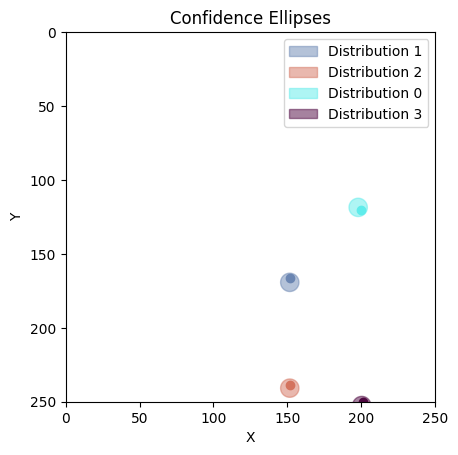

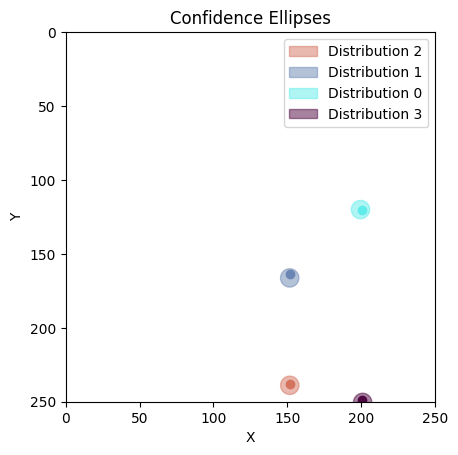

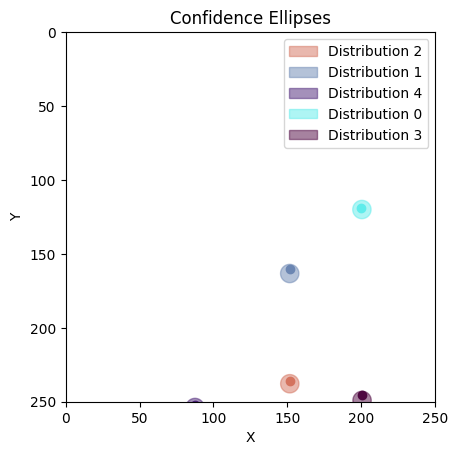

In [85]:
for i in range(100, 105):
    graph_a = train_dataset[i]
    graph_b = train_dataset[i+1]
    end_to_end_visualize_graphs_by_distributions_and_points(graph_a, graph_b)

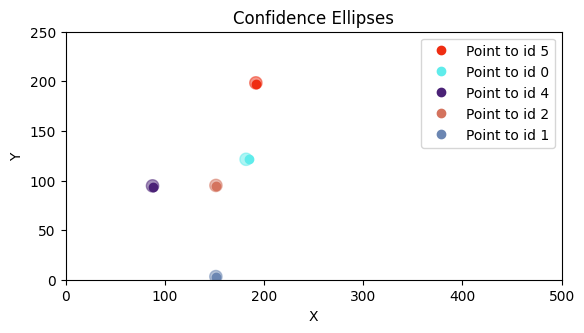

([5, 0, 4, 2, 1], array([0, 1, 2, 3, 4]))

In [67]:
# graph_a = train_dataset[200]
# graph_b = train_dataset[201]
# node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)
# node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)

# distributions_a = get_distribution_from_graph(graph_a)
# ids_a = [int(x) for x in node_attributes_a[3].tolist()]
# points_b = node_attributes_b[2]

# points_to_distributions = calc_point_indices_to_distributions(distributions_a, points_b, 0)
# end_to_end_visualize_graphs_by_distributions_and_points(graph_a, graph_b)
# ids_a, points_to_distributions

In [57]:
graph_a = train_dataset[501]
classes_points_distributions_ids_from_graph(graph_a)

(tensor([6., 1., 5., 5.]),
 tensor([[ 0.,  0., 10.,  0.,  0., 10.],
         [ 0.,  0., 10.,  0.,  0., 10.],
         [ 0.,  0., 10.,  0.,  0., 10.],
         [ 0.,  0., 10.,  0.,  0., 10.]]),
 tensor([[191.7700, 153.4400],
         [172.6750, 119.5100],
         [ 87.5650,  49.4850],
         [151.5200,  50.2650]]),
 tensor([0., 1., 2., 3.]))

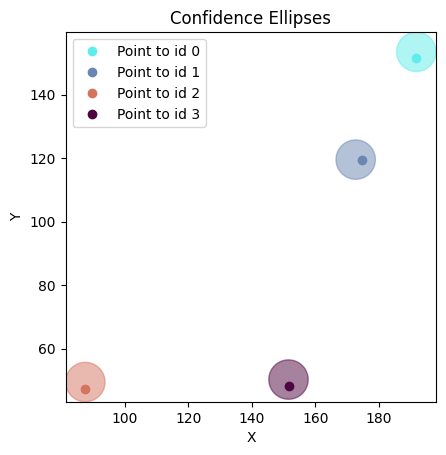

([0, 1, 2, 3], array([0, 3, 1, 2]))

In [54]:
graph_a = train_dataset[501]
graph_b = train_dataset[502]
node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)
node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)

distributions_a = get_distribution_from_graph(graph_a)
ids_a = [int(x) for x in node_attributes_a[3].tolist()]
points_b = node_attributes_b[2]

points_to_distributions = calc_point_indices_to_distributions(distributions_a, points_b, 0)
end_to_end_visualize_graphs_by_distributions_and_points(graph_a, graph_b)
ids_a, points_to_distributions

In [64]:
graph_a = train_dataset[502]
classes_points_distributions_ids_from_graph(graph_a)

(tensor([6., 5., 5., 1.]),
 tensor([[ 0.,  0., 10.,  0.,  0., 10.],
         [ 0.,  0., 10.,  0.,  0., 10.],
         [ 0.,  0., 10.,  0.,  0., 10.],
         [ 0.,  0., 10.,  0.,  0., 10.]]),
 tensor([[191.7700, 151.3900],
         [ 87.5800,  47.3900],
         [151.5250,  48.0850],
         [174.7300, 119.4850]]),
 tensor([0., 1., 2., 3.]))

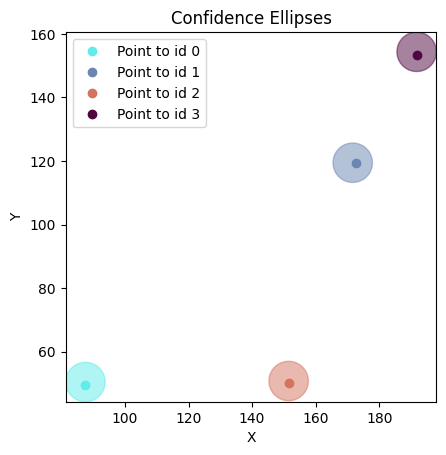

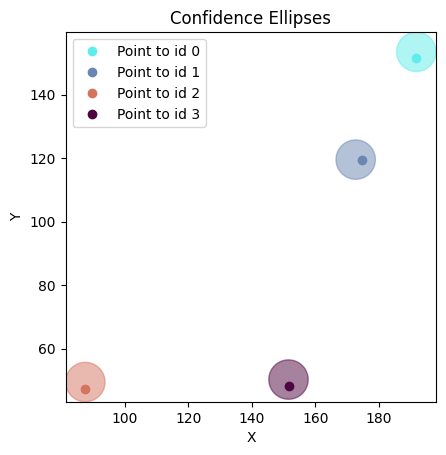

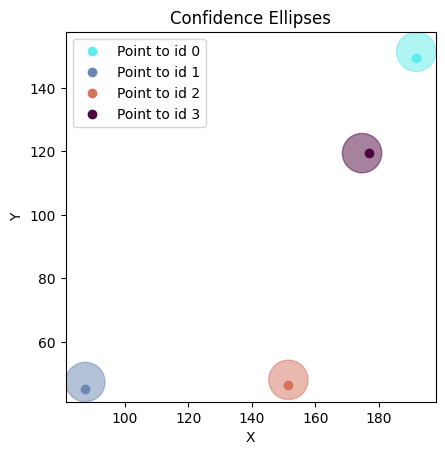

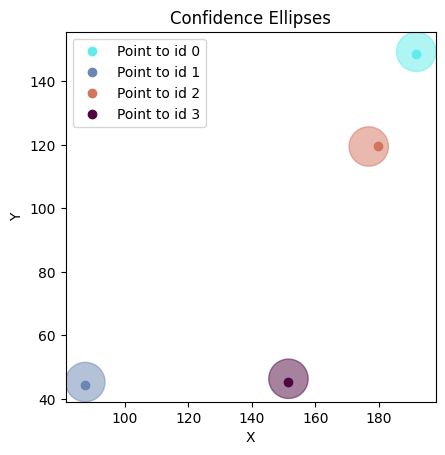

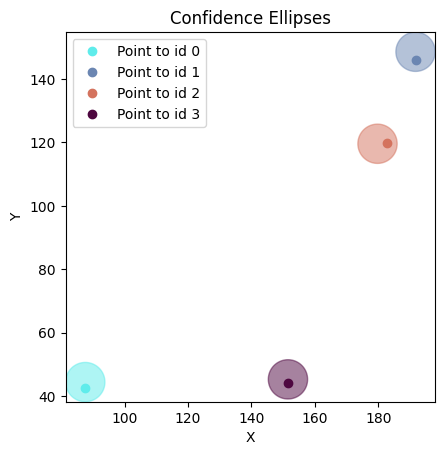

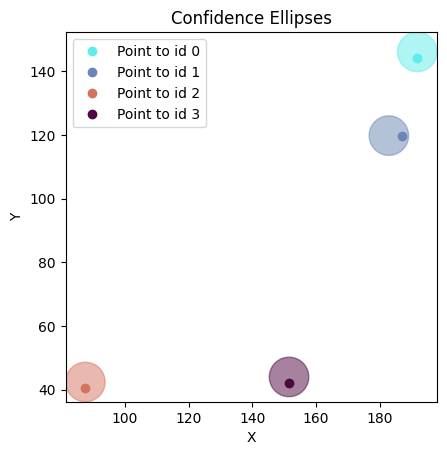

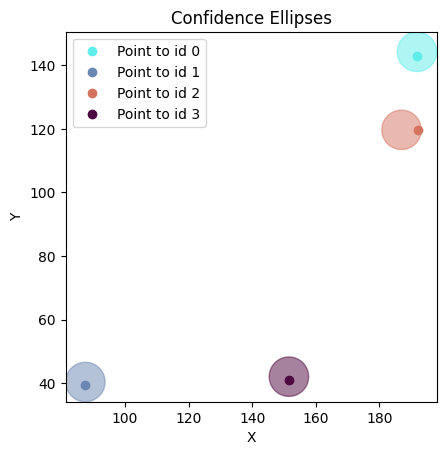

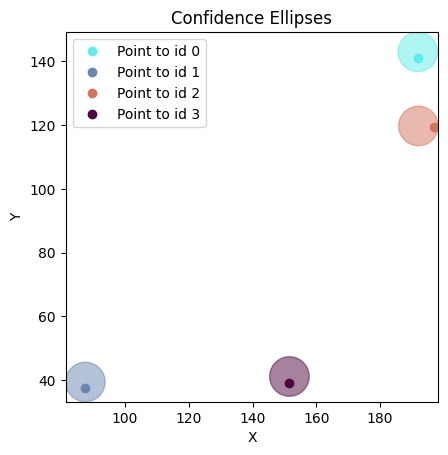

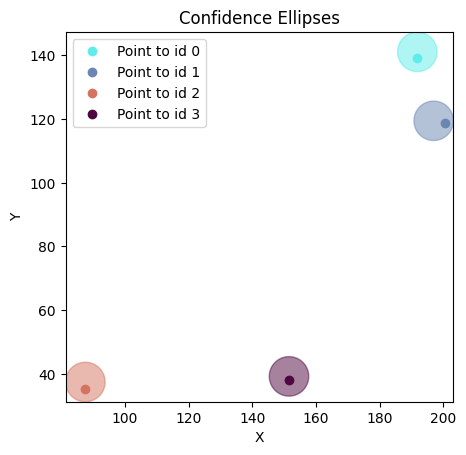

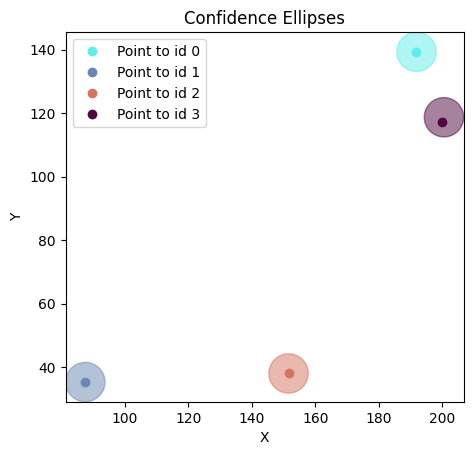

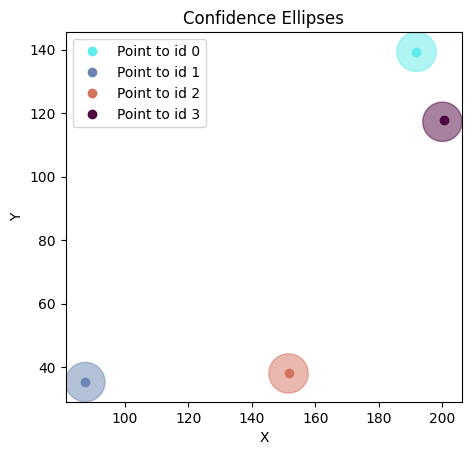

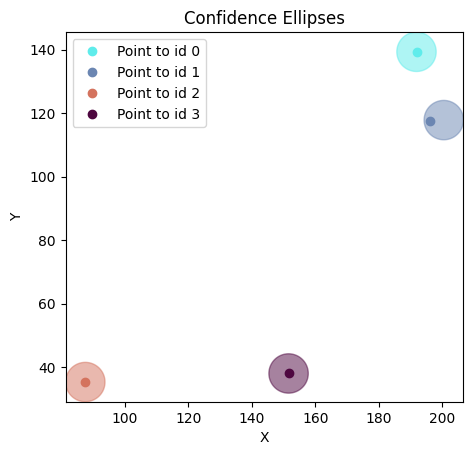

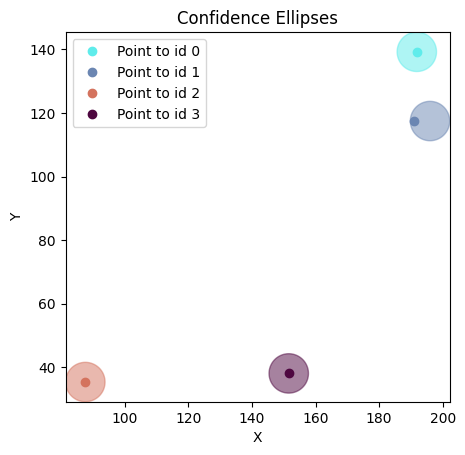

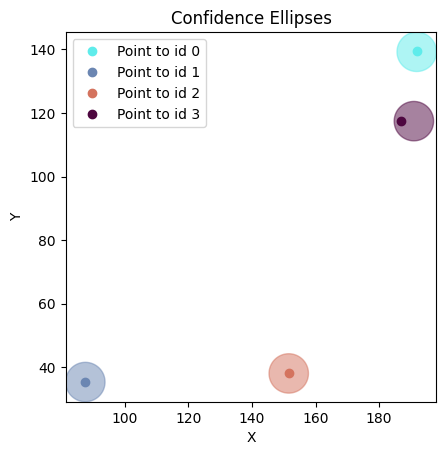

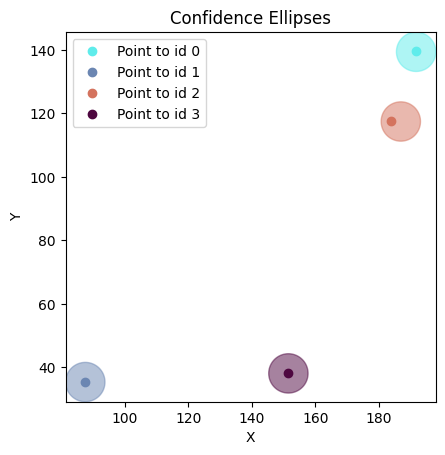

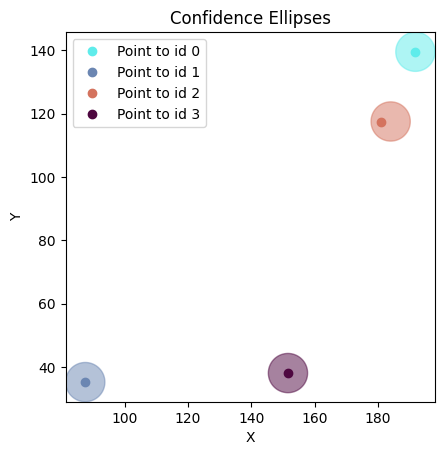

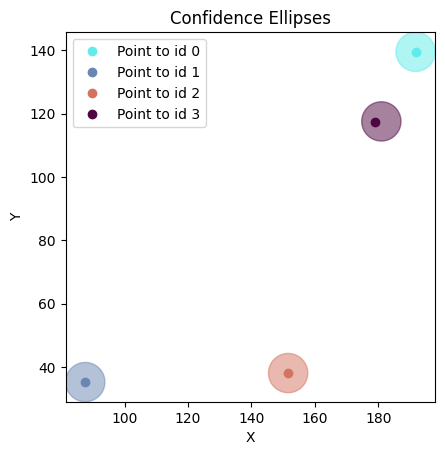

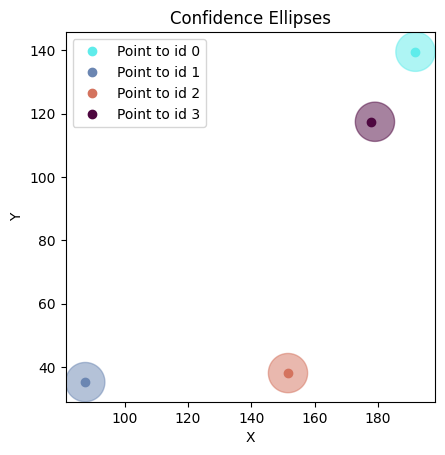

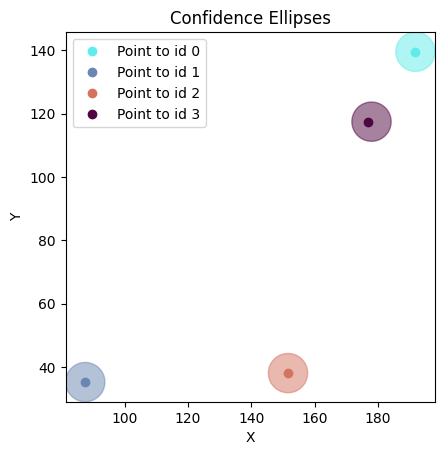

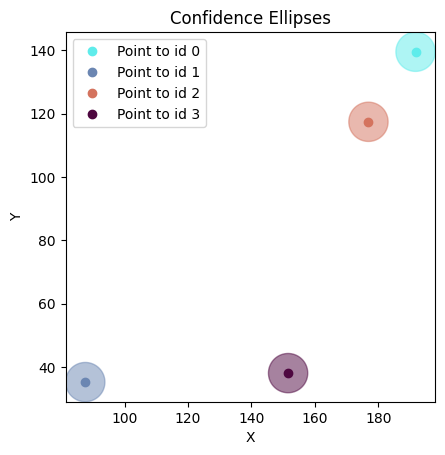

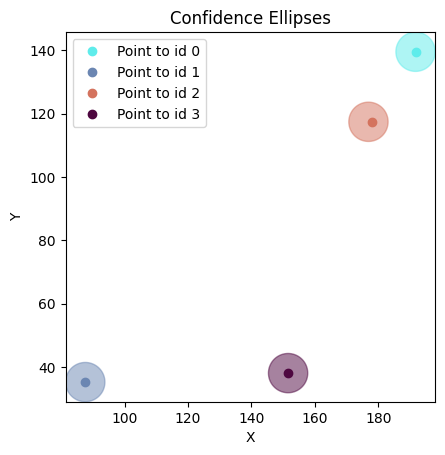

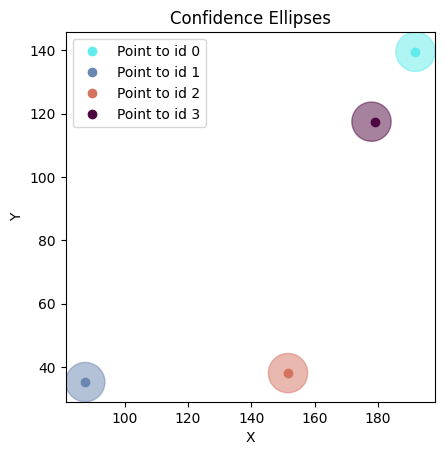

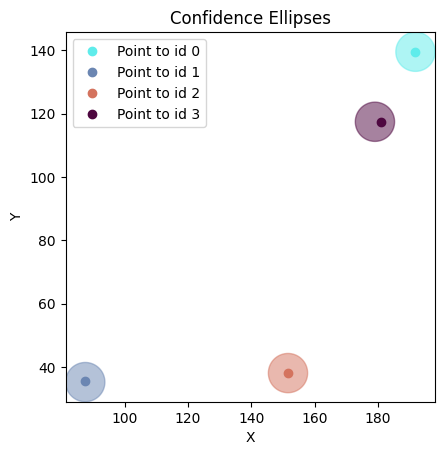

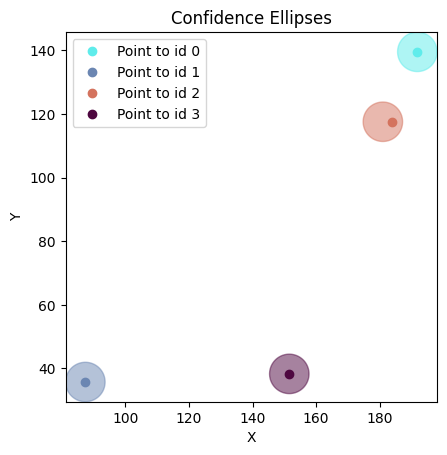

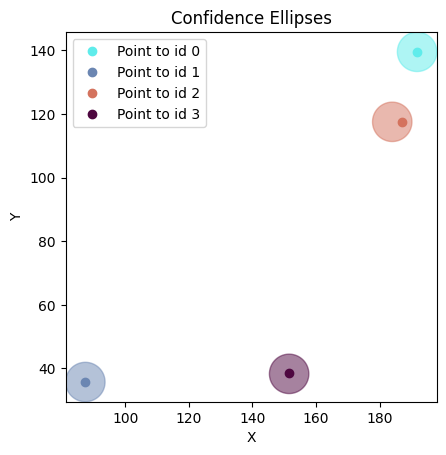

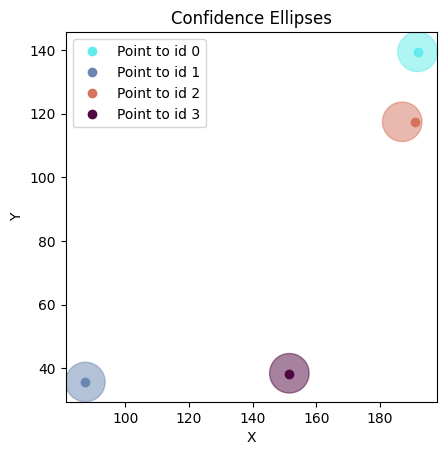

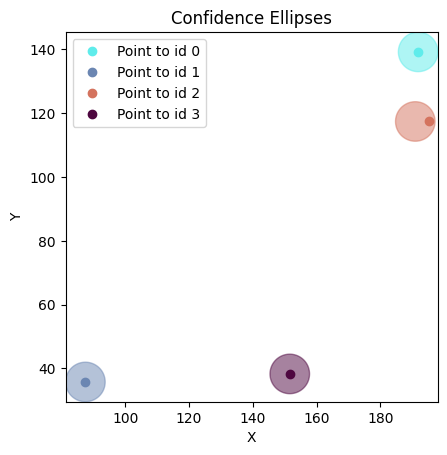

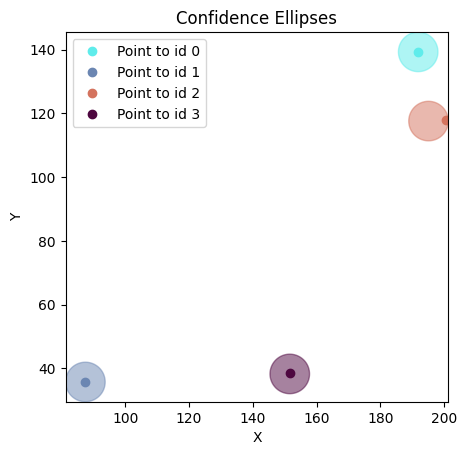

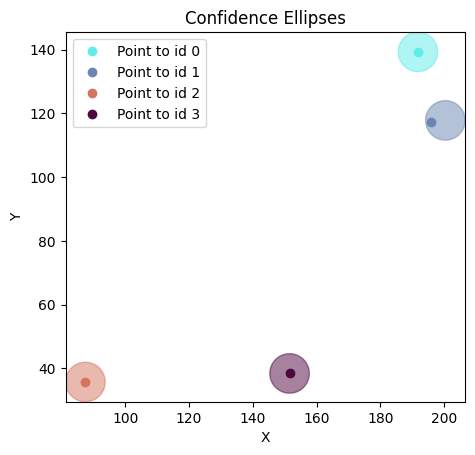

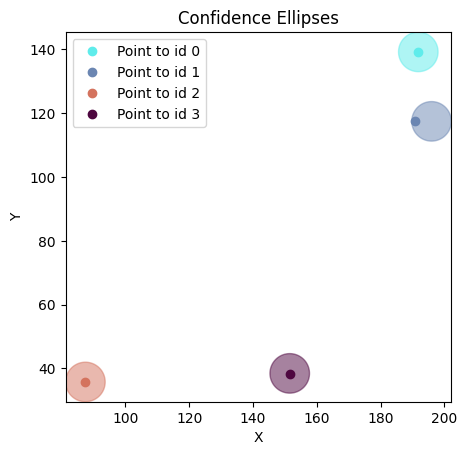

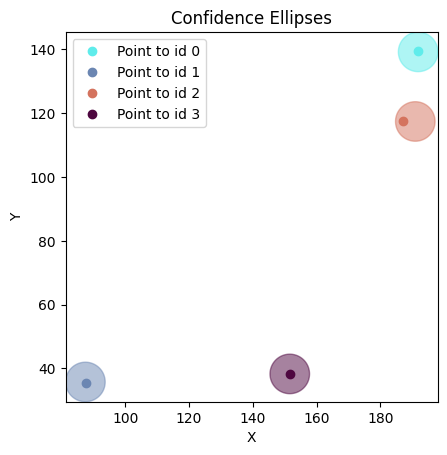

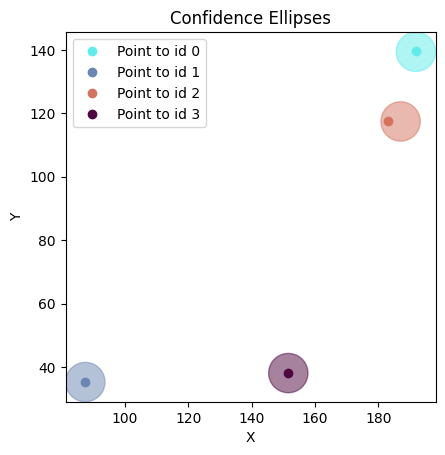

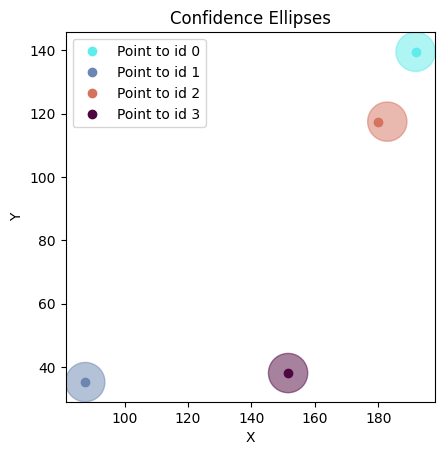

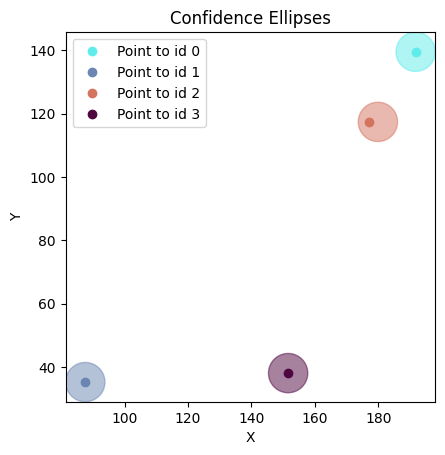

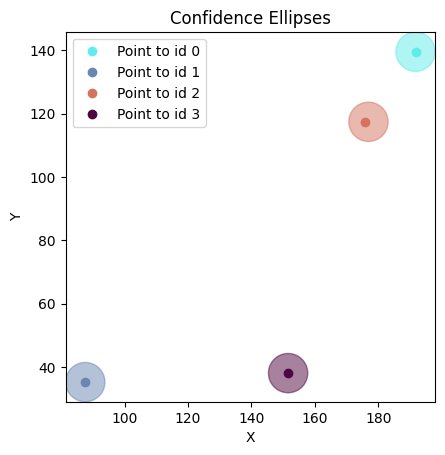

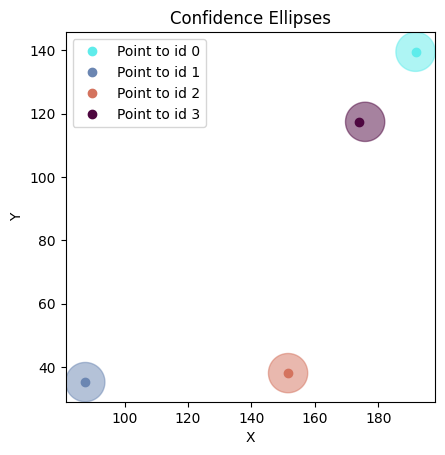

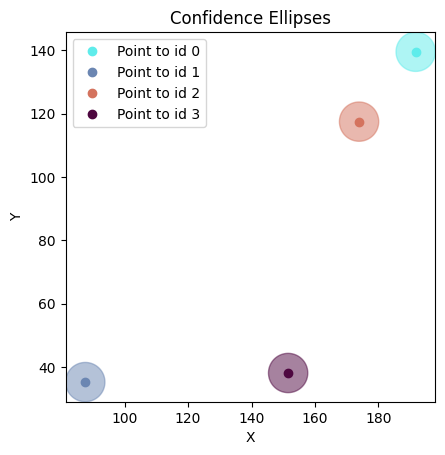

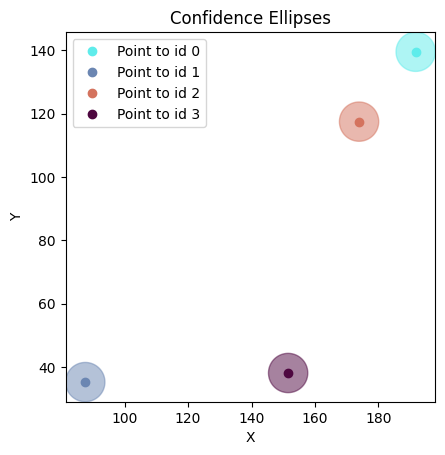

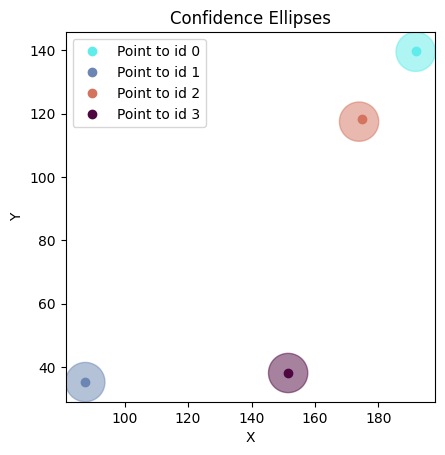

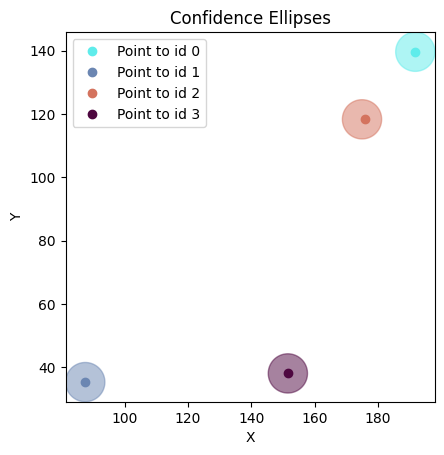

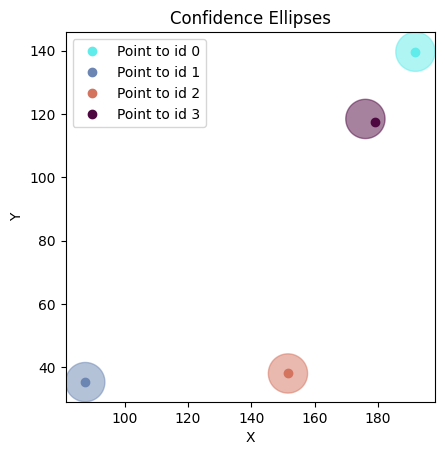

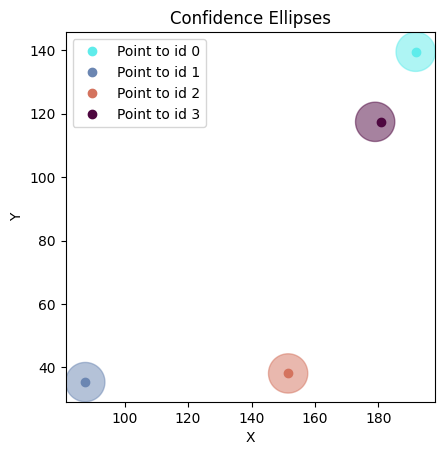

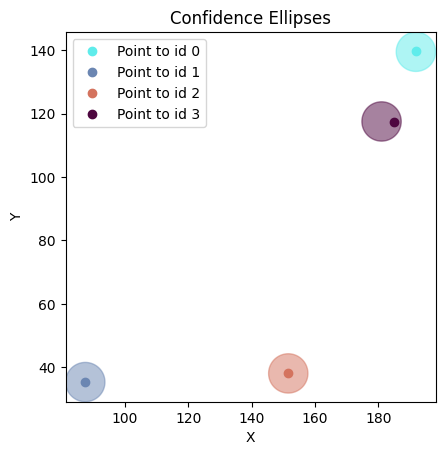

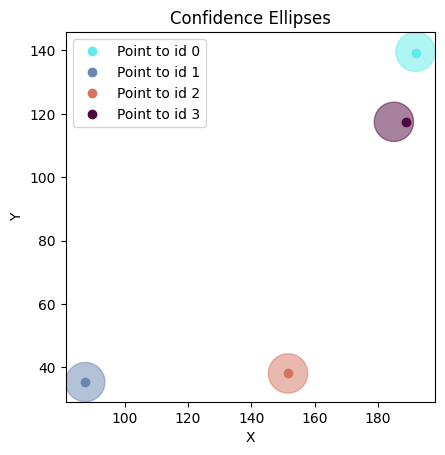

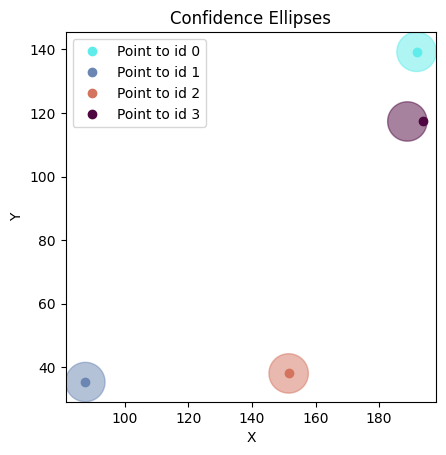

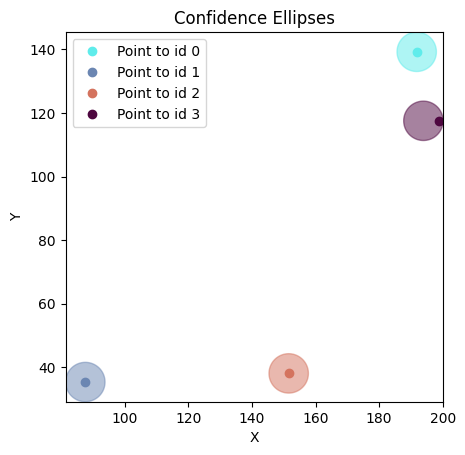

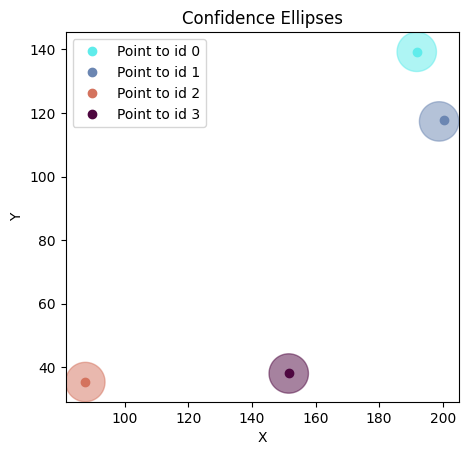

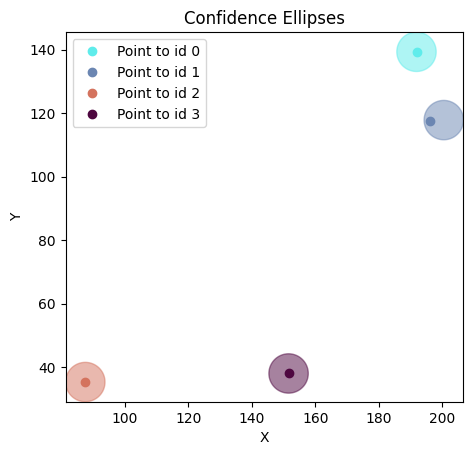

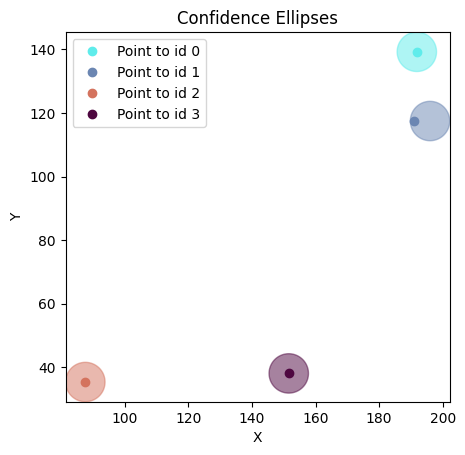

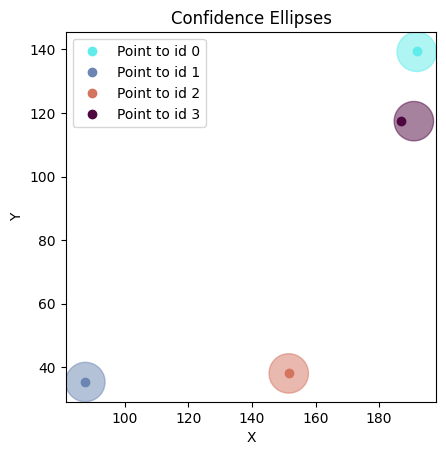

In [48]:
# for i in range(500, 550):
#     graph_a = train_dataset[i]
#     graph_b = train_dataset[i+1]
#     end_to_end_visualize_graphs_by_distributions_and_points(graph_a, graph_b)

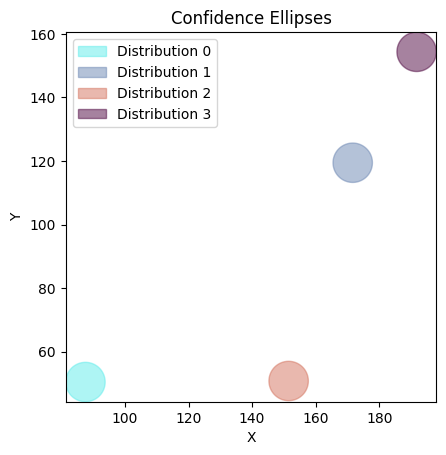

In [41]:
# # distributions

# distributions = np.array([[[ 87.575,  50.48 ],
#         [ 10.   ,   0.   ],
#         [  0.   ,  10.   ]],

#        [[171.655, 119.47 ],
#         [ 10.   ,   0.   ],
#         [  0.   ,  10.   ]],

#        [[151.495,  50.805],
#         [ 10.   ,   0.   ],
#         [  0.   ,  10.   ]],

#        [[191.765, 154.365],
#         [ 10.   ,   0.   ],
#         [  0.   ,  10.   ]]])
# ids = [0, 1, 2, 3] 

# fig, ax = plt.subplots()

# all_x, all_y = [], []
# patches = []
# for idx, dist in enumerate(distributions):
#     mean, cov = dist[0], np.array([dist[1], dist[2]])
#     x, y = create_ellipse_points(mean, cov, n_std)

#     all_x.extend(x)
#     all_y.extend(y)
    
#     # Generate color based on ID
#     color = generate_color_for_idx(ids[idx])
    
#     # Create polygon
#     polygon_points = np.column_stack([x, y])
#     poly = Polygon(polygon_points, closed=True, fill=True, color=color, alpha=0.5)
#     ax.add_patch(poly)
#     patches.append(poly)

# ax.set_xlim(min(all_x), max(all_x))
# ax.set_ylim(min(all_y), max(all_y))

# ax.set_title('Confidence Ellipses')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_aspect('equal', 'box')

# # Create a legend with IDs
# ax.legend(patches, [f'Distribution {id_}' for id_ in ids])

# plt.show()

In [ ]:
graph_a = train_dataset[298]
graph_b = train_dataset[299]

node_attributes_a = classes_points_distributions_ids_from_graph(graph_a)
node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)

distributions_a = get_distribution_from_graph(graph_a)
points_b = node_attributes_b[2]

points_to_distributions = calc_point_indices_to_distributions(distributions_a, points_b, 0)

tensor1 = node_attributes_a[3]
# tensor2 = node_attributes_b[3][points_to_distributions]
tensor2 = np.where(
    points_to_distributions != -1, 
    node_attributes_b[3][points_to_distributions], 
    -1
).flatten()

torch.tensor(list(zip(tensor1.tolist(), tensor2.tolist())), dtype=int)

In [ ]:
graph_a.x, graph_b.x

In [ ]:
points_to_distributions

In [ ]:
graph_b = train_dataset[54]
node_attributes_b = classes_points_distributions_ids_from_graph(graph_b)
node_attributes_b[3]

In [ ]:
tensor1, tensor2

In [ ]:
list(zip(tensor1.tolist(), tensor2.tolist()))

In [ ]:
torch.tensor(list(zip(tensor1.tolist(), tensor2.tolist())), dtype=int)

#### Visualize the CSV-Data

In [ ]:
import IPython.display as display
from IPython.display import clear_output
import ipywidgets as widgets
import os
import time

image_widget = widgets.Image(format='jpeg')
display.display(image_widget)

In [ ]:
# directory_name = "/workspaces/jupyterlite/workspace/supermario_graph-nn/03_supermario_graph-nn/yolo_results/clean_multiple_episodes"
# replay_csv_files_from_directory(directory_name, image_widget)

In [ ]:
# directory_name = "/workspaces/jupyterlite/content/pytroch-geometric/graph_to_csv"
# replay_csv_files_from_directory(directory_name, image_widget)

In [ ]:
directory_name = "/workspaces/jupyterlite/content/pytroch-geometric/graph_to_csv-applied_tracking"
replay_csv_files_from_directory(directory_name, image_widget)